# Thinking in tensors in PyTorch

Deep learning for neuroscientists - hands-on training  by [Piotr Migdał](https://p.migdal.pl) (2019). Version 0.2.


## Notebook 5: Image classification

Based on a beautiful dataset [Google Quickdraw](https://quickdraw.withgoogle.com/data), more about it: [Machine Learning for Visualization - Let’s Explore the Cutest Big Dataset](https://medium.com/@enjalot/machine-learning-for-visualization-927a9dff1cab) - Ian Johnson.

* Download "apple", "brain", "octopus", "snowflake" to `data`
* `pip install livelossplot` - [Live training loss plot in Jupyter Notebook for Keras, PyTorch and others](https://github.com/stared/livelossplot/) 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn.apionly as sns
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses

## What's inside?

In [2]:
!ls data/

Animals.csv                     full_numpy_bitmap_octopus.npy
full_numpy_bitmap_apple.npy     full_numpy_bitmap_snowflake.npy
full_numpy_bitmap_brain.npy


## Data loading

I.e. the boring part.

In [3]:
classes = ["apple", "brain", "octopus", "snowflake"]
size = 28
limit = 500

X_list = []

for c in classes:
    X_c = np.load("data/full_numpy_bitmap_{}.npy".format(c))
    print("Loaded {} out of {} {}s".format(limit, X_c.shape[0], c))
    X_list.append(X_c[:limit])

X = np.concatenate(X_list)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 500 out of 144722 apples
Loaded 500 out of 143033 brains
Loaded 500 out of 150152 octopuss
Loaded 500 out of 116685 snowflakes


In [4]:
X.dtype

dtype('uint8')

In [5]:
X.shape

(2000, 784)

In [6]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  11,  21,  12,   0,   0,   0,   0,   0,   0,   0,
         0,  92,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  91, 213, 253, 255, 255, 222,  95,   3,   0,   0,
         0,   0,   7, 255, 222,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  24, 190, 255, 196, 118, 100, 109, 196, 255, 121,
         0,   0,   0,   0,   0, 141,  35,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1, 185, 241,  94,   1,   0,   0,   0,   0,
        63,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  89, 255, 115, 133, 150,  37,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 207, 241, 252, 25

In [7]:
X[0].reshape(28, 28)[:10, :10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  89],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 207],
       [  0,   0,   0,   0,   0,   0,   0,  30, 200, 255],
       [  0,   0,   0,   0,   0,   0,  39, 225, 238, 255],
       [  0,   0,   0,   0,   0,  43, 229, 231, 106, 255]], dtype=uint8)

In [9]:
X = X.reshape(-1, 1, size, size)
X = X.astype('float32') / 255.

In [10]:
# (samples, channels, x, y)
X.shape

(2000, 1, 28, 28)

In [11]:
# answer keys are integers
Y.dtype

dtype('int64')

## Train-test split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## First, let's have a look

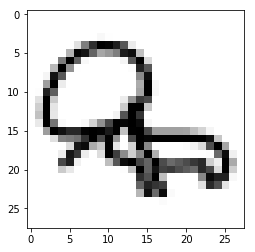

In [18]:
plt.imshow(X_train[53].reshape(28, 28), cmap='Greys');

In [15]:
Y_train[:20]

array([3, 1, 1, 2, 3, 3, 2, 0, 3, 2, 0, 0, 1, 2, 3, 3, 1, 0, 3, 2])

In [19]:
def draw_examples(X, Y, classes, rows=6, scale=1):
    fig, axs = plt.subplots(rows, len(classes), figsize=(scale * len(classes), scale * rows))
    size = X.shape[-1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        for i in range(rows):
            ax = axs[i, class_id]
            x = X_class[np.random.randint(len(X_class))].reshape(size, size)
            ax.imshow(x, cmap='Greys', interpolation='none')
            ax.axis('off')

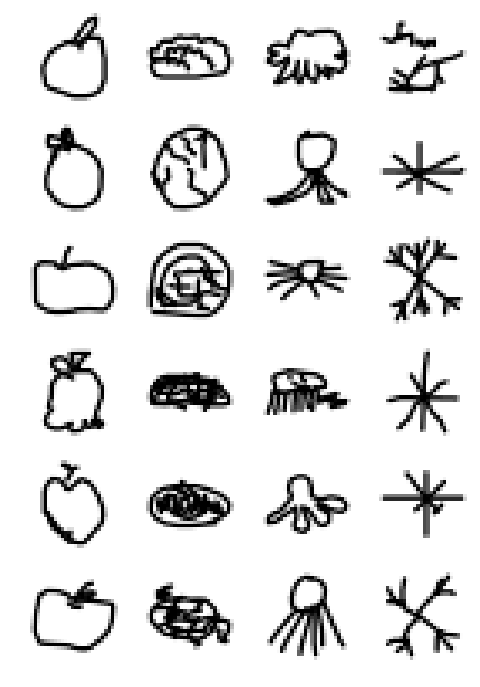

In [20]:
draw_examples(X_train, Y_train, classes, rows=6, scale=2)

## Per-class averages

Vide [this tweet](https://twitter.com/kcimc/status/902229612666658816)

In [21]:
def draw_class_averages(X, Y, classes, scale=2):
    fig, axs = plt.subplots(1, len(classes), figsize=(scale * len(classes), scale))
    size = X.shape[-1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        ax = axs[class_id]
        x = X_class.mean(axis=0).reshape(size, size)
        ax.imshow(x, cmap='Greys', interpolation='none')
        ax.axis('off')

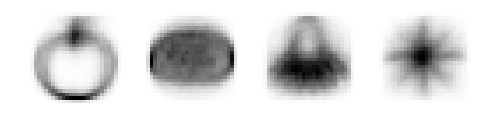

In [22]:
draw_class_averages(X_train, Y_train, classes)

## Datasets and data loaders

We need to create data loaders to load and preprocess data. We use split:
* train - for training,
* validation - not used for training, but to evaluate model performance.

In [34]:
torch.from_numpy(Y_train).long().dtype

torch.int64

In [35]:
# download CIFAR10 train and validation datasets

# define data loaders
dataloaders = {
    'train':
    DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).long()),
               batch_size=64,
               shuffle=True, num_workers=4),
    'validation': 
    DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).long()),
               batch_size=64,
               shuffle=False, num_workers=4)
}

## Before we start

While training a model, it is important to set `train` or `eval` mode of the model, as some layers have different behavior during train and evaluation.

See also: [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning) which explains API differences between these frameworks.

In [36]:
device

device(type='cpu')

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()
    return model

## Logistic regression

Multi-class logistic regression can be expressed as a shallow neural network consisting of one linear layer and a softmax activation function.

For binary classification, we can use sigmoid (a.k.a. logistic function):

$$ \sigma(x) = \frac{1}{1+\exp(-x)} $$

Softmax function transforms any vector into distribution vector (values in range (0., 1.) that sum up to 1.):
$$\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

We use a cross-entropy loss function:
$$- \sum_j p_{j, true} \log(p_{j, pred})$$

Note that we do not state explicitly the softmax function in the model class below. For details see [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).

See also:

* [Cross-entropy vs. mean-squared error loss](https://www.reddit.com/r/MachineLearning/comments/8im9eb/d_crossentropy_vs_meansquared_error_loss/)
* [Cross entropy](https://pandeykartikey.github.io/machine/learning/basics/2018/05/22/cross-entropy.html) - another explanation
* [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)
* [Multiclass logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)

In [38]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, len(classes))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

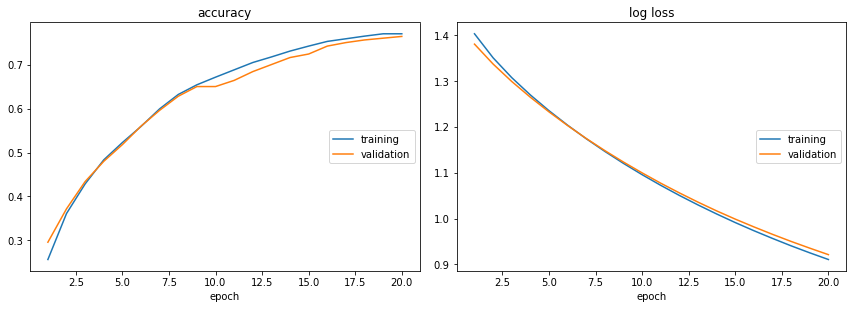

accuracy:
training   (min:    0.257, max:    0.770, cur:    0.770)
validation (min:    0.296, max:    0.764, cur:    0.764)

log loss:
training   (min:    0.911, max:    1.402, cur:    0.911)
validation (min:    0.921, max:    1.380, cur:    0.921)


In [28]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

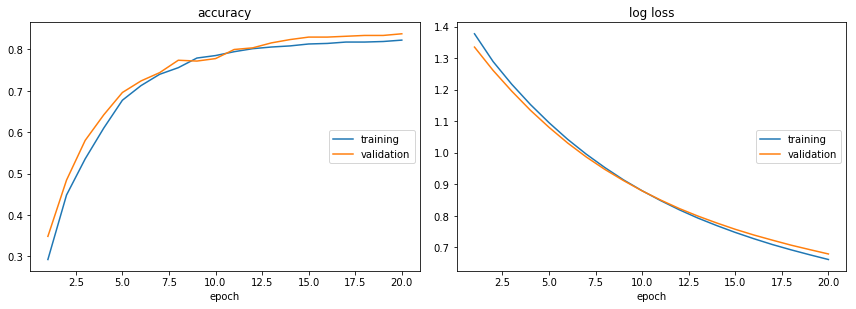

accuracy:
training   (min:    0.292, max:    0.823, cur:    0.823)
validation (min:    0.348, max:    0.838, cur:    0.838)

log loss:
training   (min:    0.661, max:    1.377, cur:    0.661)
validation (min:    0.679, max:    1.335, cur:    0.679)


In [47]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=100.)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


model_trained = train_model(model, criterion, optimizer, num_epochs=20)

## Predictions

In [30]:
pred_logit = model(torch.from_numpy(X_test[:5]))
pred_logit

tensor([[-1.4055,  0.4973, -0.1433,  0.6620],
        [-0.1279,  0.6395, -0.3048, -0.3995],
        [-1.2440, -0.2897,  1.0528, -0.2031],
        [ 0.6516,  0.0400, -0.8609, -0.2727],
        [-0.8693, -0.4061,  1.0179,  0.1194]], grad_fn=<AddmmBackward>)

In [31]:
F.softmax(pred_logit, dim=1)

tensor([[0.0522, 0.3502, 0.1846, 0.4130],
        [0.2103, 0.4531, 0.1762, 0.1603],
        [0.0611, 0.1586, 0.6073, 0.1730],
        [0.4630, 0.2512, 0.1020, 0.1837],
        [0.0842, 0.1338, 0.5557, 0.2263]], grad_fn=<SoftmaxBackward>)

### Exercise

Make some changes and see how it goes.

Hints:

* Test optim.SGD learning rate (e.g. x0.1 and x10).
* Use optim.Adam instead of optim.SGD.

Optimizers are important, see:

* [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/) by Sebastian Ruder
* [SGD > Adam?? Which One Is The Best Optimizer: Dogs-VS-Cats Toy Experiment | SALu](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/)

tl;dr: If you don't now what to do, use Adam.

## Old school neural network

Linear layers are also called dense layers or fully-connected layers. Stacking a few of them gives a model called multilayer perceptron (MLP). Importantly, we need to use an activation function for our network to be nonlinear transformation. Here we use sigmoid activation function.

In [55]:
class MLP(nn.Module):
    def __init__(self, hidden_1=128, activation='sigmoid'):
        super().__init__()
        func = {'sigmoid': nn.Sigmoid(), 
                'relu': nn.ReLU(),
                'tanh': nn.Tanh()}[activation]
        self.fc = nn.Sequential(
            nn.Linear(1 * 28 * 28, hidden_1),
            func,
            #nn.Linear(128, 128),
            #func,
            nn.Linear(hidden_1, len(classes))
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

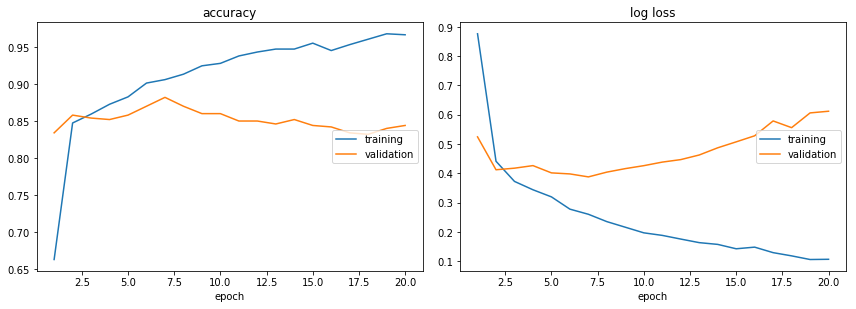

accuracy:
training   (min:    0.663, max:    0.968, cur:    0.967)
validation (min:    0.832, max:    0.882, cur:    0.844)

log loss:
training   (min:    0.106, max:    0.876, cur:    0.107)
validation (min:    0.388, max:    0.612, cur:    0.612)


In [52]:
model = MLP(hidden_1=2048)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

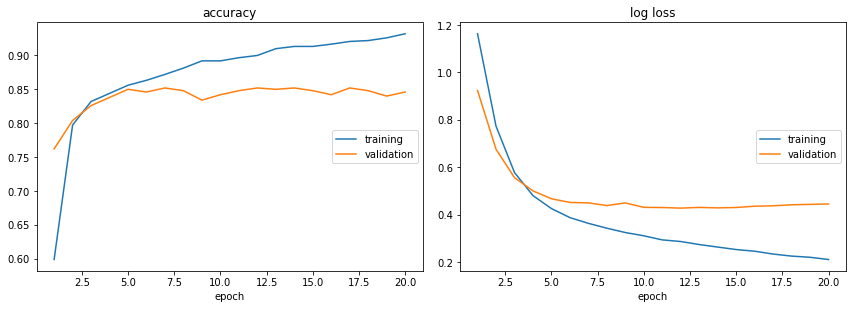

accuracy:
training   (min:    0.599, max:    0.932, cur:    0.932)
validation (min:    0.762, max:    0.852, cur:    0.846)

log loss:
training   (min:    0.210, max:    1.163, cur:    0.210)
validation (min:    0.427, max:    0.924, cur:    0.445)


In [58]:
model = MLP(hidden_1=16, activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

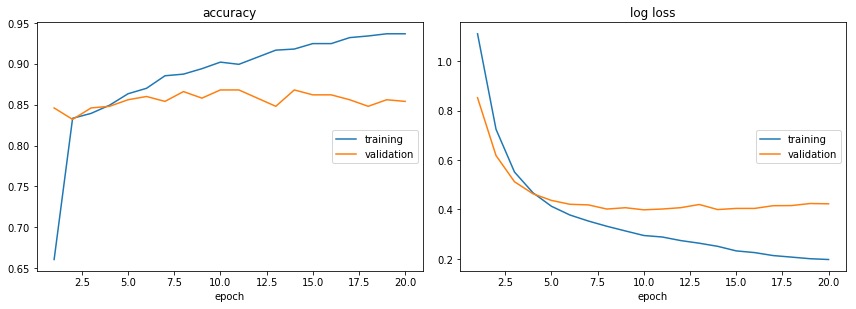

accuracy:
training   (min:    0.661, max:    0.937, cur:    0.937)
validation (min:    0.832, max:    0.868, cur:    0.854)

log loss:
training   (min:    0.197, max:    1.111, cur:    0.197)
validation (min:    0.399, max:    0.852, cur:    0.423)


In [54]:
model = MLP(hidden_1=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

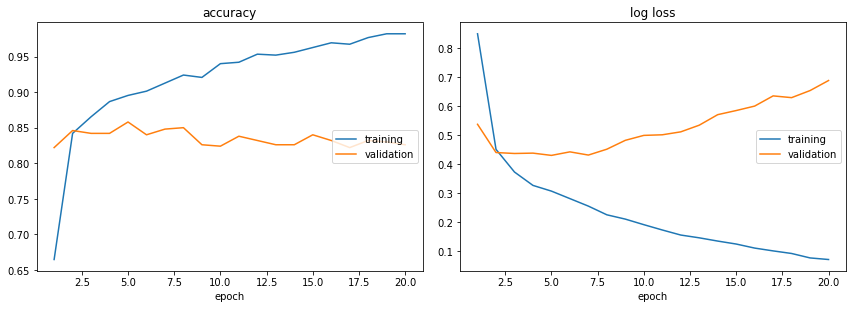

accuracy:
training   (min:    0.665, max:    0.982, cur:    0.982)
validation (min:    0.822, max:    0.858, cur:    0.826)

log loss:
training   (min:    0.072, max:    0.849, cur:    0.072)
validation (min:    0.430, max:    0.688, cur:    0.688)


In [57]:
model = MLP(hidden_1=128, activation='tanh')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

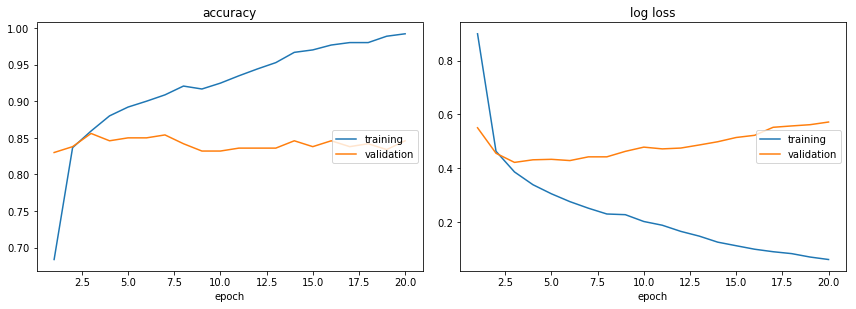

accuracy:
training   (min:    0.684, max:    0.992, cur:    0.992)
validation (min:    0.830, max:    0.856, cur:    0.846)

log loss:
training   (min:    0.061, max:    0.900, cur:    0.061)
validation (min:    0.422, max:    0.572, cur:    0.572)


In [56]:
model = MLP(hidden_1=128, activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

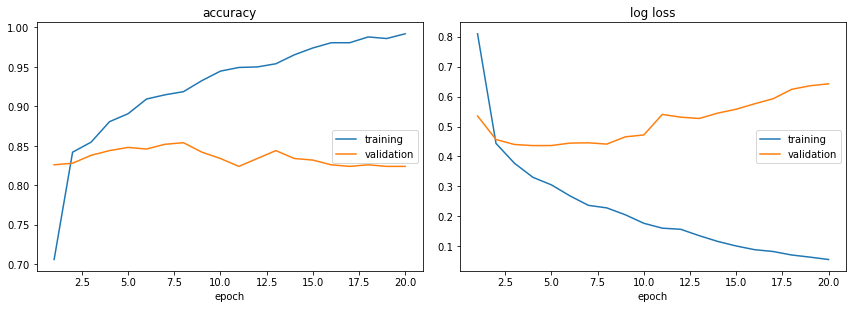

accuracy:
training   (min:    0.706, max:    0.992, cur:    0.992)
validation (min:    0.824, max:    0.854, cur:    0.824)

log loss:
training   (min:    0.056, max:    0.810, cur:    0.056)
validation (min:    0.436, max:    0.643, cur:    0.643)


In [53]:
class Sin(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.sin()

class MLP_sin(nn.Module):
    def __init__(self, hidden_1=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1 * 28 * 28, hidden_1),
            Sin(),
            #nn.Linear(128, 128),
            #nn.Sigmoid(),
            nn.Linear(hidden_1, len(classes))
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MLP_sin(hidden_1=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

### Exercise

Make some changes and see how it goes.

Hints:

* Use Tanh or ReLU instead of Sigmoid.
* Use more than 20 epochs.
* In practice, neural networks use 2-3 dense layers.
* Make big changes to see a difference. In this case change the hidden layer size by 2x or even 10x.

## Convolutional neural network

Treating an image as a flat vector looses its spatial structure. Instead we can use the spacial structure in our advantage and perform convolutions.
Convolution is an operation which performs the same local operation on each part of the image.

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true)

Each convolution layer produces new channels based on those which preceded it. First, we start with 3 channels for red, green and blue (RGB) components. Next, channels get more and more abstract.

While producing new channels with representations of various properties of the image, we also reduce the resolution, usually using pooling layers.

See also:
* [Image Kernels - visually explained](http://setosa.io/ev/image-kernels/)
* [How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)
* source of above image: [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)
* [Convolutional Neural Networks by Andrej Karpathy](http://cs231n.github.io/convolutional-networks/) for in-depth explanation of convolutions and other accompanying blocks

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(32 * 7 * 7, len(classes))
    
    
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [60]:
# or we can modularize that
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            self._block(1, 16),
            self._block(16, 32)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, len(classes)) # dropout pomiedzy gestymi
        )
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),  # batch norm 2d
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

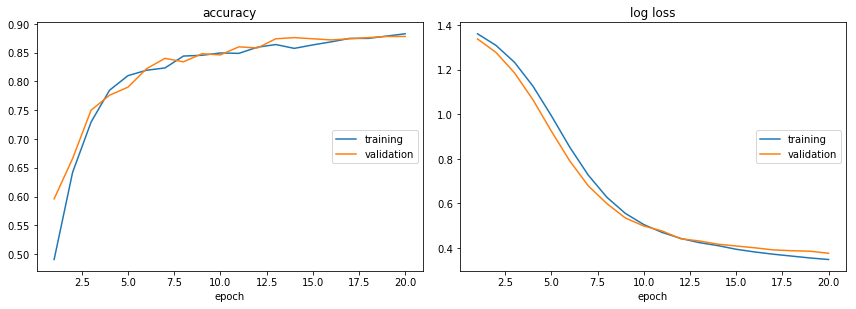

accuracy:
training   (min:    0.491, max:    0.883, cur:    0.883)
validation (min:    0.596, max:    0.878, cur:    0.878)

log loss:
training   (min:    0.348, max:    1.361, cur:    0.348)
validation (min:    0.376, max:    1.338, cur:    0.376)


In [61]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

## Exercise
Now, feel free to experiment.

Hints:
* Play with the number of channels and how they grow.
* Usually 3×3 convolutions work the best; stick to them (and 1×1 convolutions which only mix channels).
* You can have 1-3 convolutional layers before each MaxPool operation.
* Adding a Dense layer may help.
* Between dense layers you can use Dropout, to reduce overfitting (i.e. if you see that training accuracy is higher than validation accuracy).


In [62]:
def plot_preditions(model, X, Y, classes, rows=6, only_wrong=False):
    
    # very greedy
    preds = F.softmax(model(torch.from_numpy(X)), dim=1).detach().numpy()
    
    if only_wrong:
        incorrect = preds.argmax(1) != Y
        preds = preds[incorrect]
        X = X[incorrect]
        Y = Y[incorrect]

    fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
    for i in range(rows):
        ax = axs[i, 0]
        ax.imshow(X[i].reshape(size, size),
                  cmap='Greys', interpolation='none')

        ax.axis('off')
    
        pd.DataFrame({"pred": preds[i], "true": [int(Y[i] == j) for j in range(len(classes))]}, index=classes) \
          .plot(kind='barh', ax=axs[i, 1], xlim=[0, 1], stacked=True, legend=False)
        
    fig.tight_layout()

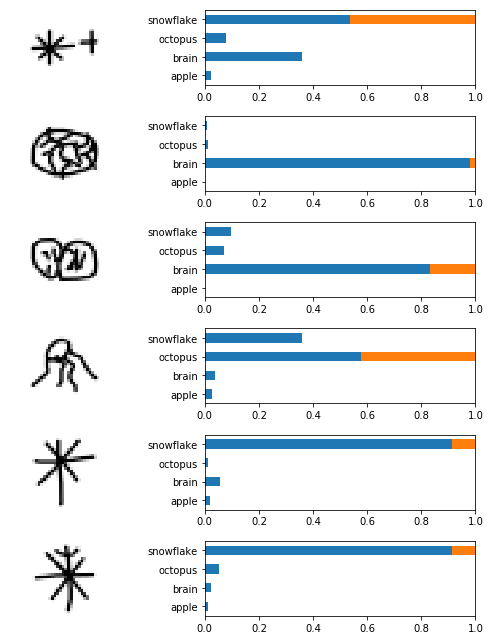

In [64]:
plot_preditions(model, X_train, Y_train, classes)

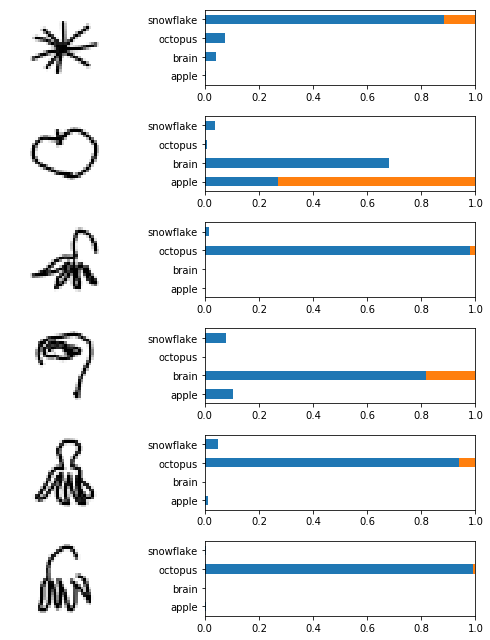

In [65]:
plot_preditions(model, X_test, Y_test, classes)

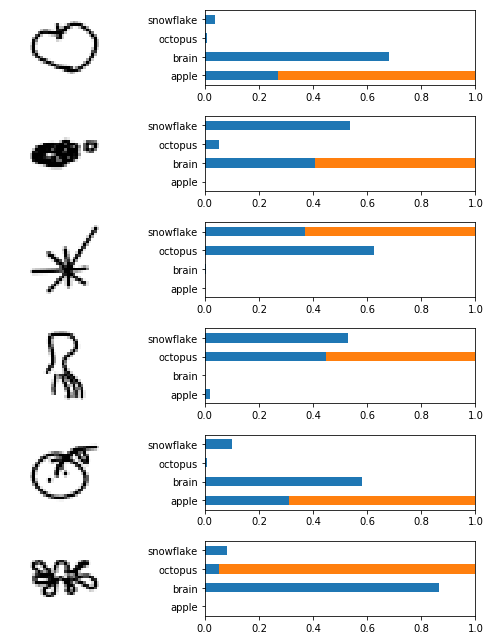

In [66]:
plot_preditions(model, X_test, Y_test, classes, only_wrong=True)

## Quantify confusion

In [67]:
preds = model(torch.from_numpy(X_test)).detach().numpy().argmax(1)
cm = confusion_matrix(Y_test, preds)
cm

array([[126,   6,   2,   2],
       [  0, 111,   4,   6],
       [  2,   6,  95,  10],
       [  1,   7,  15, 107]])

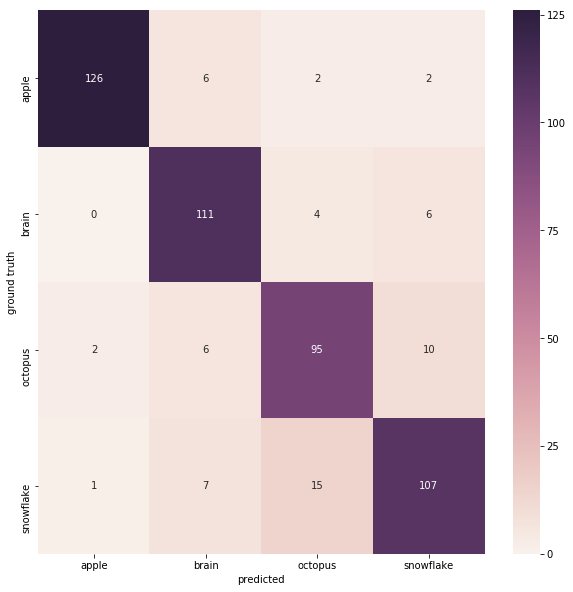

In [68]:
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df.columns.name = "predicted"
cm_df.index.name = "ground truth"

plt.subplots(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt='d')

In [69]:
def confusion_image_matrix(model, X, Y, classes, size=28):
    confused = np.zeros((len(classes), len(classes), size, size), dtype='float32')
    Y_pred = model(torch.from_numpy(X)).detach().numpy().argmax(1)
    for x, y_true, y_pred in zip(X, Y, Y_pred):
        confused[y_true, y_pred] = x[0, :, :]

    fig, axs = plt.subplots(len(classes), len(classes), figsize=(2*len(classes), 2*len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax = axs[i, j]
            ax.imshow(confused[i, j], cmap='Greys', interpolation='none')
            ax.axis('off')

    fig.suptitle('predicted', fontsize=16)
    for ax, c in zip(axs[0], classes):
            ax.set_title(c)

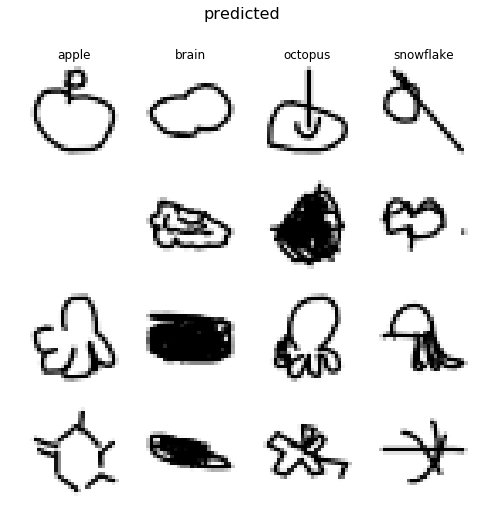

In [70]:
confusion_image_matrix(model, X_test, Y_test, classes)

## Further notes

If you want to learn more, some relevant blog posts:

* [Data science intro for math/phys background](http://p.migdal.pl/2016/03/15/data-science-intro-for-math-phys-background.html)
* [Learning Deep Learning with Keras](https://p.migdal.pl/2017/04/30/teaching-deep-learning.html)
* [Keras or PyTorch as your first deep learning framework](https://deepsense.ai/keras-or-pytorch/) (previously with an inflammatory title *Don't learn TensorFlow - start with Keras or PyTorch instead*)
* [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/) with interactive code in Jupyter Notebook: https://www.kaggle.com/pmigdal/alien-vs-predator-images/kernels
* [Simple diagrams of convoluted neural networks](https://medium.com/inbrowserai/simple-diagrams-of-convoluted-neural-networks-39c097d2925b) - In Browser AI
